In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [4]:
# Read File
ab_testing = pd.read_csv('/Users/xiejing/Desktop/Codeoptest/Group_Project/ab_testing.csv')

## 1. Introduction

### 1.1 Conversion Rate

#### To have a initial probe of the dataset, columns, shape, valye counts, conversion rate comparison, etc

In [5]:
ab_testing.shape

(5000, 7)

In [4]:
ab_testing.columns

Index(['User ID', 'Group', 'Page Views', 'Time Spent', 'Conversion', 'Device',
       'Location'],
      dtype='object')

In [7]:
ab_testing['Group'].value_counts()

Group
A    2519
B    2481
Name: count, dtype: int64

In [36]:
# 1: Count total users per group
total_users = ab_testing.groupby('Group').size()

# 2: Count converted users (Conversion == 'Yes') per group
converted_users = ab_testing[ab_testing['Conversion'] == 'Yes'].groupby('Group').size()

# 3: Calculate conversion rate per group
conversion_rate_manual = (converted_users / total_users) * 100

print(conversion_rate_manual)


Group
A     5.398968
B    14.066909
dtype: float64


In [8]:
ab_testing[ab_testing['Conversion'] == 'Yes']['Group'].value_counts()

Group
B    349
A    136
Name: count, dtype: int64

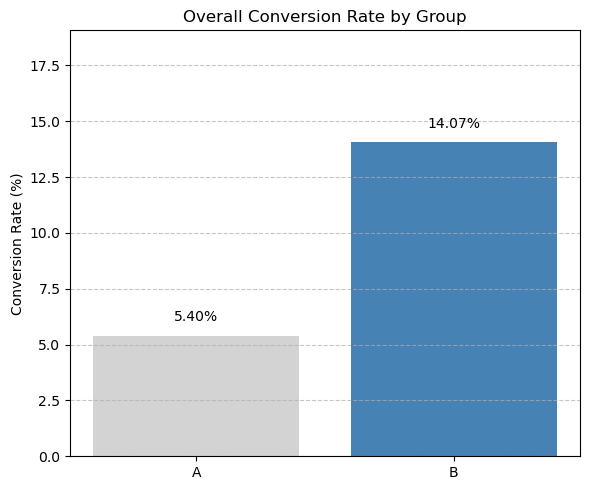

In [39]:
# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(conversion_rate_manual.index, conversion_rate_manual.values, color=['lightgray', 'steelblue'])

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Overall Conversion Rate by Group')
plt.ylabel('Conversion Rate (%)')
plt.ylim(0, max(conversion_rate_manual.values) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 2. Core Data Analysis + Visualization
- check if the data needs to be cleaned;
- Scatter plot of Page Views vs Time Spent colored by Conversion 
- Conversion Rate by deviced and location (also check if it aligns with the real-world demographic distribution)

### 2.1 Cleaning Data

In [28]:
# Corrected numerical columns
numerical_cols = ['Page Views', 'Time Spent']

outlier_summary = {}

# Analyze for outliers and missing values
for col in numerical_cols:
    summary = {
        'min': ab_testing[col].min(),
        '1st_quartile': ab_testing[col].quantile(0.25),
        'median': ab_testing[col].median(),
        '3rd_quartile': ab_testing[col].quantile(0.75),
        'max': ab_testing[col].max(),
        'IQR': ab_testing[col].quantile(0.75) - ab_testing[col].quantile(0.25),
        'missing_values': ab_testing[col].isnull().sum()
    }
    outlier_summary[col] = summary

outlier_summary


{'Page Views': {'min': 1,
  '1st_quartile': 4.0,
  'median': 8.0,
  '3rd_quartile': 11.0,
  'max': 14,
  'IQR': 7.0,
  'missing_values': 0},
 'Time Spent': {'min': 40,
  '1st_quartile': 137.0,
  'median': 243.0,
  '3rd_quartile': 346.0,
  'max': 449,
  'IQR': 209.0,
  'missing_values': 0}}

No evident outliers were found, the data was pretty clean.

###  2.2 scatter plot of Page Views vs Time Spent colored by Conversion

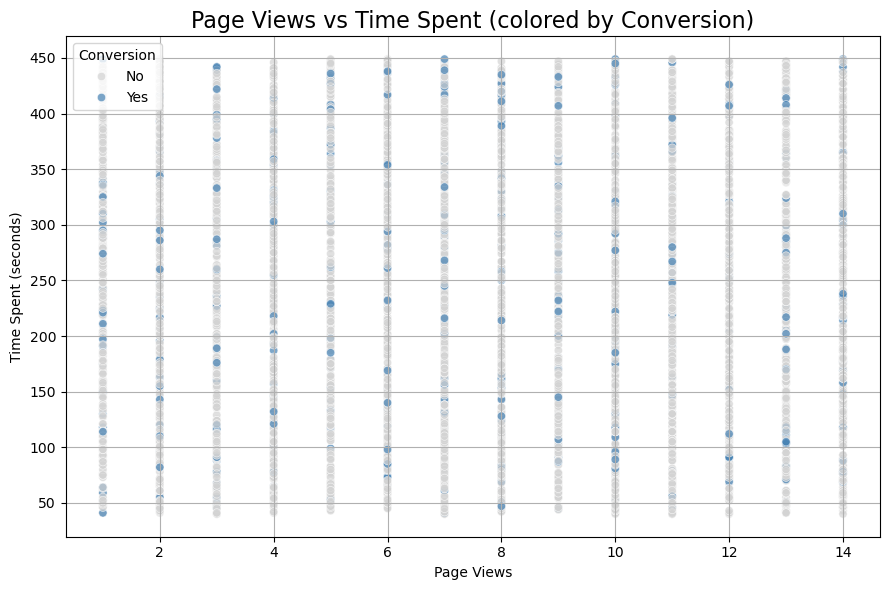

In [40]:

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=ab_testing,
    x='Page Views',
    y='Time Spent',
    hue='Conversion',
    palette={'Yes': 'steelblue', 'No': 'lightgray'},
    alpha=0.7
)

plt.title('Page Views vs Time Spent (colored by Conversion)', fontsize=16)
plt.xlabel('Page Views')
plt.ylabel('Time Spent (seconds)')
plt.grid(True)
plt.legend(title='Conversion')
plt.tight_layout()
plt.show()


The graph is not ideal, no clear pattern is visually detected, tableau gives a better visual

### 2.3 Calculate conversion rates by location

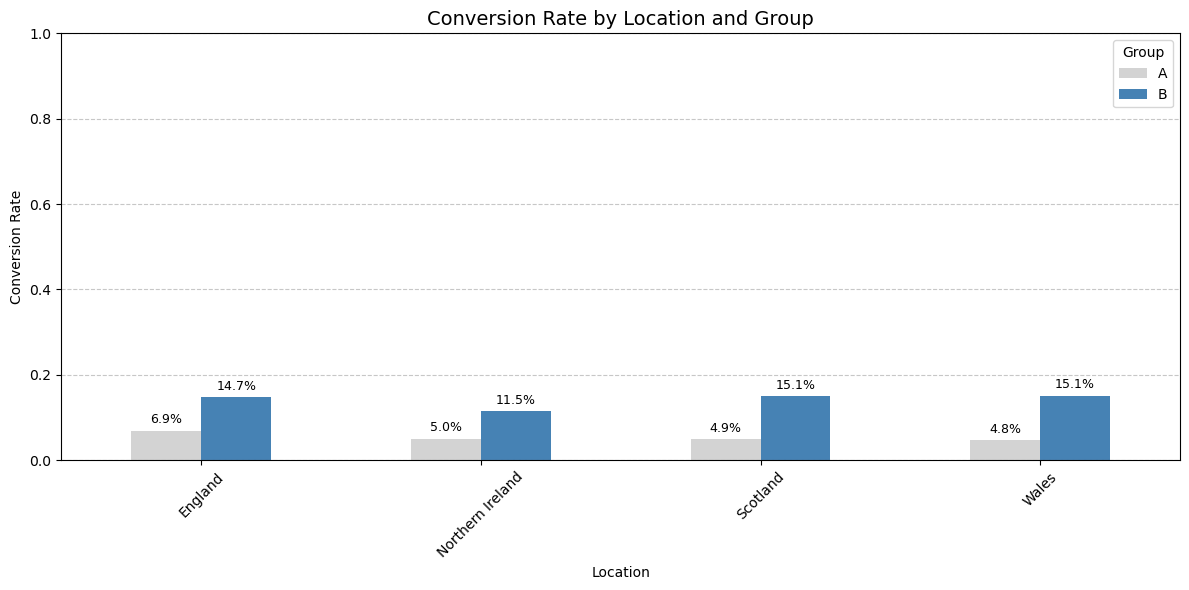

In [42]:

# Calculate conversion counts by Location and Group
location_group_conversion = (
    ab_testing.groupby(['Location', 'Group', 'Conversion'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Calculate conversion rate per group and location
location_group_conversion['Conversion Rate'] = (
    location_group_conversion['Yes'] /
    (location_group_conversion['Yes'] + location_group_conversion['No'])
)

# Pivot for plotting
plot_data = location_group_conversion.pivot(index='Location', columns='Group', values='Conversion Rate')

# Plot
# Recreate the bar plot with labels
ax = plot_data.plot(kind='bar', color=['lightgray', 'steelblue'], figsize=(12, 6))

plt.title('Conversion Rate by Location and Group', fontsize=14)
plt.ylabel('Conversion Rate')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Group')
plt.tight_layout()

# Add data labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.1%}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center', va='bottom', fontsize=9)

plt.show()



In [43]:
# Filter for Northern Ireland
ni_data = ab_testing[ab_testing['Location'] == 'Northern Ireland']

# Count number of users per group in Northern Ireland
ni_group_counts = ni_data['Group'].value_counts()

# Also calculate conversions per group in Northern Ireland
ni_conversion = ni_data.groupby(['Group', 'Conversion']).size().unstack(fill_value=0)
ni_conversion['Total'] = ni_conversion.sum(axis=1)
ni_conversion['Conversion Rate'] = ni_conversion['Yes'] / ni_conversion['Total']

ni_group_counts, ni_conversion


(Group
 B    628
 A    614
 Name: count, dtype: int64,
 Conversion   No  Yes  Total  Conversion Rate
 Group                                       
 A           583   31    614         0.050489
 B           556   72    628         0.114650)

While the overall A/B test showed a positive uplift in conversion with the new black background design, regional differences suggest that the impact was not consistent across the UK. In particular, users in Northern Ireland responded less positively to the design change compared to other regions. this is where I started questioning if the sample of this region is proportionally distributed, so I did the following check on numbers of users from Northern Ireland, then I realise it seems consists of nearly 25% of the total user count, which does not seem aligh with the demograohic reality inthe UK. 

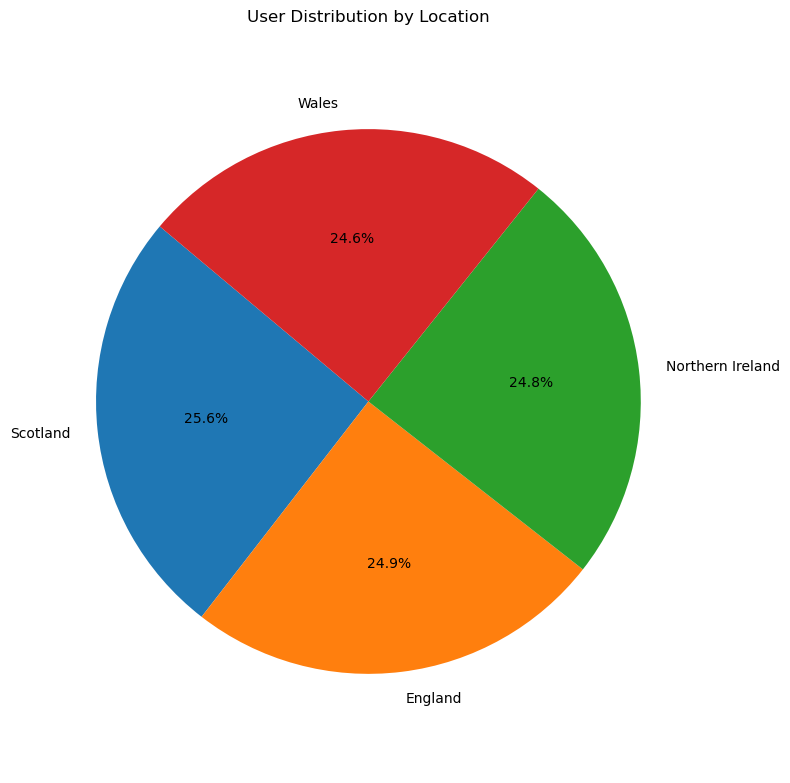

Location
Scotland            25.62
England             24.92
Northern Ireland    24.84
Wales               24.62
Name: proportion, dtype: float64

In [46]:
# Calculate percentage of users by location in this dataset
location_counts = ab_testing['Location'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('User Distribution by Location')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

location_counts


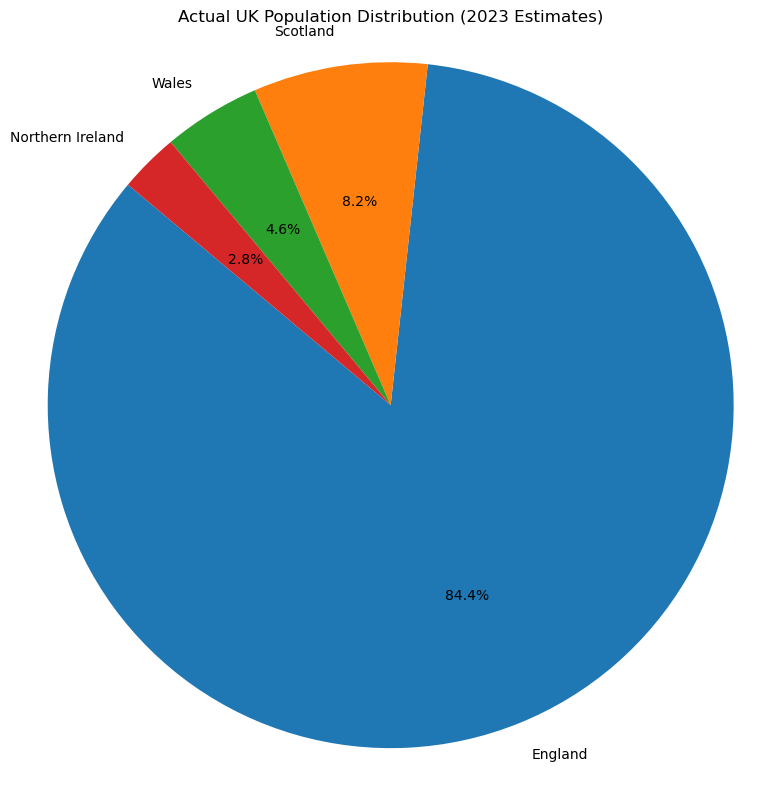

In [45]:
# Real population distribution (2023 mid-year estimates)
uk_population = {
    'England': 84.3,
    'Scotland': 8.2,
    'Wales': 4.6,
    'Northern Ireland': 2.8
}

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(uk_population.values(), labels=uk_population.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Actual UK Population Distribution (2023 Estimates)')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.tight_layout()
plt.show()


Source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/bulletins/annualmidyearpopulationestimates/mid2023?utm_source=chatgpt.com

### "Note on Dataset Limitations"
This dataset was synthetically generated for analysis and testing purposes. It includes an equal distribution of users across the four UK regions(≈25% each), which does not reflect the actual population distribution (e.g., England accounts for over 80% of the UK population). As such, insights based on region should be interpreted as internally valid within the dataset, but not representative of real-world demographic proportions."

For real-world application, further validation on demographically representative data is recommended.

### 2.4 Calculate conversion rates by Device


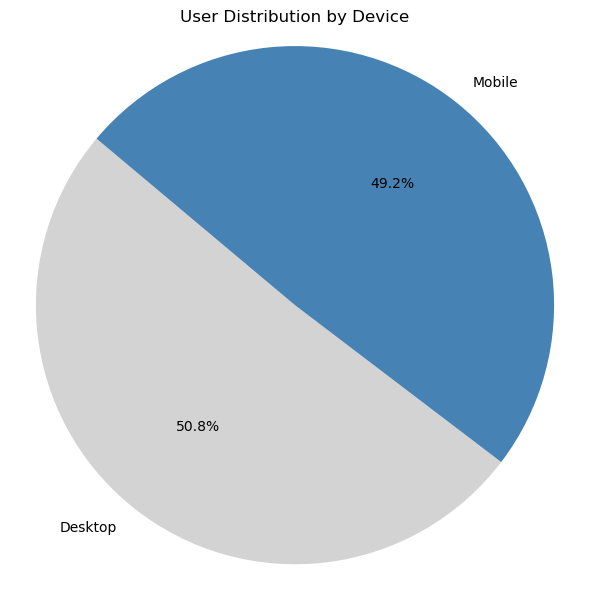

Device
Desktop    50.76
Mobile     49.24
Name: proportion, dtype: float64

In [34]:
# Calculate total counts of users by device
device_counts = ab_testing['Device'].value_counts(normalize=True) * 100

# Plot pie chart
plt.figure(figsize=(6, 6))
colors = ['lightgray', 'steelblue', 'lightcoral']
plt.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('User Distribution by Device')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

# Return actual percentages for reference
device_counts


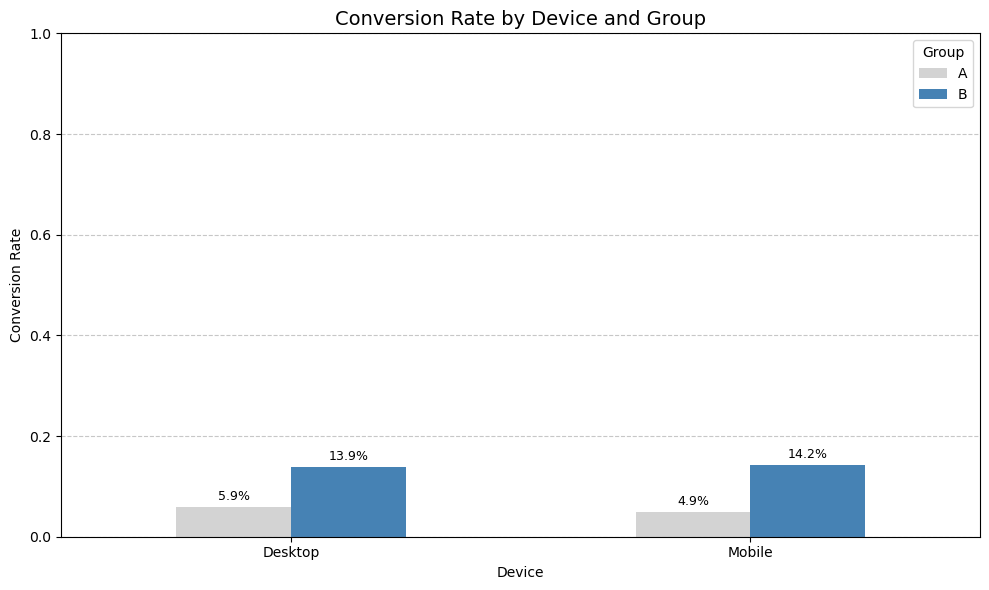

In [35]:
# Calculate conversion counts by Device and Group
device_group_conversion = (
    ab_testing.groupby(['Device', 'Group', 'Conversion'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Calculate conversion rate per group and device
device_group_conversion['Total'] = device_group_conversion['Yes'] + device_group_conversion['No']
device_group_conversion['Conversion Rate'] = device_group_conversion['Yes'] / device_group_conversion['Total']

# Pivot the data for plotting
plot_device = device_group_conversion.pivot(index='Device', columns='Group', values='Conversion Rate')

# Plot grouped bar chart with labels
ax = plot_device.plot(kind='bar', figsize=(10, 6), color=['lightgray', 'steelblue'])

plt.title('Conversion Rate by Device and Group', fontsize=14)
plt.ylabel('Conversion Rate')
plt.xlabel('Device')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Group')
plt.tight_layout()

# Add data labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.1%}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center', va='bottom', fontsize=9)

plt.show()


The black background design improved conversion rates across all device types, with no segment performing worse than the control. This suggests the variation is broadly compatible and effective across platforms, making it a safe choice for full rollout."

## 3. Statistical Test & Insights Exploration

### 3.1  Chi-Square Test for Conversion Rate difference between Group A and Group B

To help determine whether the observed difference in conversion rates is statistically significant — or just due to random chance.

In [16]:
from scipy.stats import chi2_contingency

# Create the contingency table: Group vs Conversion outcome
conversion_table = pd.crosstab(ab_testing['Group'], ab_testing['Conversion'])

# Run the Chi-Square test
chi2, p, dof, expected = chi2_contingency(conversion_table)

# Output results
chi2_result = {
    "Chi-Square Statistic": chi2,
    "p-value": p,
    "Degrees of Freedom": dof,
    "Expected Frequencies": expected
}
conversion_table, chi2_result


(Conversion    No  Yes
 Group                
 A           2383  136
 B           2132  349,
 {'Chi-Square Statistic': 106.22812337440538,
  'p-value': 6.571736018334225e-25,
  'Degrees of Freedom': 1,
  'Expected Frequencies': array([[2274.657,  244.343],
         [2240.343,  240.657]])})

#### Interpretation
The p-value is extremely small, which means the difference in conversion rates between Group A and Group B is statistically significant.

This suggests that the change was made in Group B had a real impact on conversion behavior — it’s not due to random chance.


### 3.2 Z-Test

In [20]:

from statsmodels.stats.proportion import proportions_ztest

# Count conversions and totals for each group
conversion_counts = ab_testing[ab_testing['Conversion'] == 'Yes'].groupby('Group')['Conversion'].count()
total_counts = ab_testing.groupby('Group')['Conversion'].count()

# Prepare counts (ensure order is Group A, Group B)
successes = [conversion_counts.get('A', 0), conversion_counts.get('B', 0)]
totals = [total_counts.get('A', 0), total_counts.get('B', 0)]

# Run two-proportion z-test
z_stat, p_value = proportions_ztest(count=successes, nobs=totals)

z_stat, p_value


(-10.354488520266216, 3.9931511894201938e-25)

- same conclusion with z-test as the P value is exremetely lower than 0.05


### 3.3 Correlation analysis

In [23]:

from scipy.stats import pearsonr, spearmanr, pointbiserialr

# Encode 'Conversion' as numeric for correlation purposes (Yes = 1, No = 0)
ab_testing['Conversion Numeric'] = ab_testing['Conversion'].map({'No': 0, 'Yes': 1})

### 1️⃣ Page Views ↔ Time Spent
pearson_pv_ts, _ = pearsonr(ab_testing['Page Views'], ab_testing['Time Spent'])
spearman_pv_ts, _ = spearmanr(ab_testing['Page Views'], ab_testing['Time Spent'])

print(f"Page Views ↔ Time Spent:")
print(f"  Pearson correlation: {pearson_pv_ts:.3f}")
print(f"  Spearman correlation: {spearman_pv_ts:.3f}\n")

### 2️⃣ Page Views ↔ Conversion (Point-biserial correlation)
r_pb_pv, _ = pointbiserialr(ab_testing['Conversion Numeric'], ab_testing['Page Views'])
print(f"Page Views ↔ Conversion (Point-biserial): {r_pb_pv:.3f}")

### 3️⃣ Time Spent ↔ Conversion (Point-biserial correlation)
r_pb_ts, _ = pointbiserialr(ab_testing['Conversion Numeric'], ab_testing['Time Spent'])
print(f"Time Spent ↔ Conversion (Point-biserial): {r_pb_ts:.3f}")


Page Views ↔ Time Spent:
  Pearson correlation: -0.001
  Spearman correlation: -0.001

Page Views ↔ Conversion (Point-biserial): -0.018
Time Spent ↔ Conversion (Point-biserial): 0.002


Correlation analysis reveals that neither additional page views nor extended time spent on site are significantly associated with higher conversion likelihood.

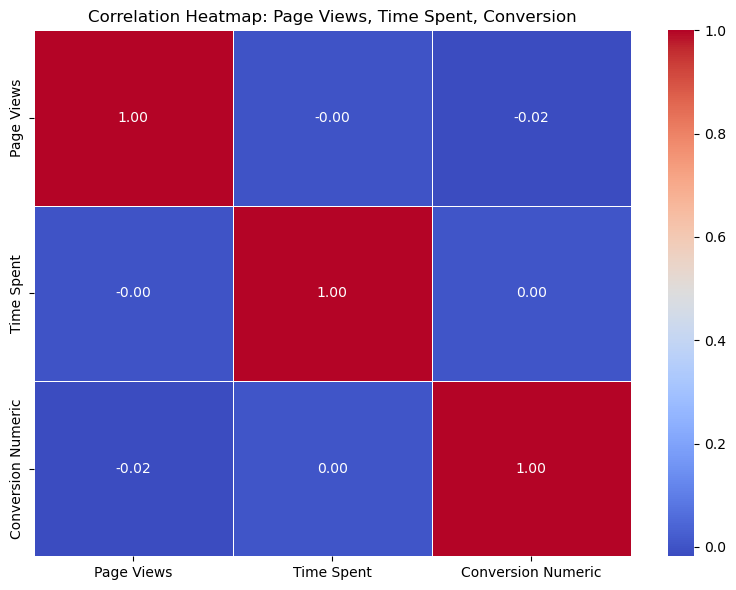

In [27]:
ab_testing['Conversion Numeric'] = ab_testing['Conversion'].map({'No': 0, 'Yes': 1})

corr_data = ab_testing[['Page Views', 'Time Spent', 'Conversion Numeric']]

# Calculate correlation matrix
corr_matrix = corr_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Page Views, Time Spent, Conversion')
plt.tight_layout()
plt.show()


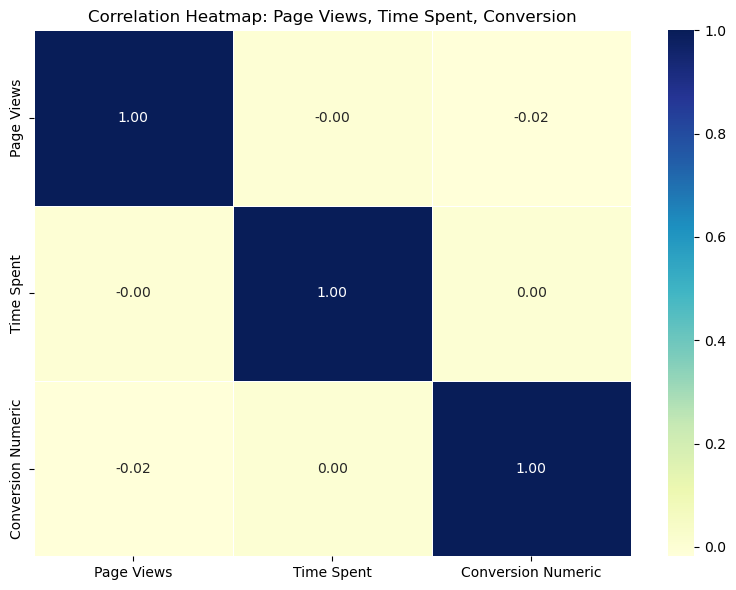

In [17]:

# Use a green to orange custom colormap
custom_cmap = sns.color_palette("RdYlGn_r", as_cmap=True)

# Recalculate correlation matrix (just to ensure fresh context)
ab_testing['Conversion Numeric'] = ab_testing['Conversion'].map({'No': 0, 'Yes': 1})
corr_data = ab_testing[['Page Views', 'Time Spent', 'Conversion Numeric']]
corr_matrix = corr_data.corr()

# Use a lighter custom green-to-orange colormap
lighter_cmap = sns.color_palette("YlGnBu", as_cmap=True)  # Lighter greens and blues

# Plot with the adjusted lighter colormap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap=lighter_cmap, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Page Views, Time Spent, Conversion')
plt.tight_layout()
plt.show()
